In [1]:
import shapely
import shapely.vectorized
import re
from itertools import product, combinations

from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopy
import geopy.distance
import xarray as xr
import seaborn as sns
import geopandas
from scipy.spatial import distance
import cartopy.io.shapereader as shpreader
import numpy as np
import pandas as pd
import time

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

In [2]:
def match_shp_da(shpfile, ndf, shpfile_name, shp_ndf_df):

    shp_ndf = []

    degrees = abs(ndf.LAT.unique()[1] - ndf.LAT.unique()[0])
    yv, xv = np.meshgrid(ndf.LAT.unique(), ndf.LON.unique())
    xv[xv>180] -= 360

    for i, place in shpfile.iterrows():

        inplace = shapely.vectorized.contains(place.geometry,xv,yv)

        idx = np.argwhere(inplace==True)
        ndots = idx.size/2

        if ndots==0:
            c = np.array(place.geometry.centroid)
            lon = c[0]//degrees*degrees+degrees*0.5
            lat = c[1]//degrees*degrees+degrees*0.5
            da_df = ndf[(ndf['LON']==lon) & (ndf['LAT']==lat)]
            if da_df.shape[0]==0:
                print(lat,lon)
            shpfile.loc[i, 'gridcells'] = 1

            shp_ndf.append({"shpfile_name": shpfile_name, "shpfile_id": i, "ndf_id": da_df.index[0]})

        else:

            for point in idx:
                lon = ndf.LON.unique()[point[0]]
                lat = ndf.LAT.unique()[point[1]]
                da_df = ndf[(ndf['LON']==lon) & (ndf['LAT']==lat)]
                shp_ndf.append({"shpfile_name": shpfile_name, "shpfile_id": i, "ndf_id": da_df.index[0]})

        shpfile.loc[i,'gridcells'] = ndots


    shp_ndf_df = pd.concat([shp_ndf_df, pd.DataFrame.from_dict(shp_ndf)])

    return shpfile, shp_ndf_df

In [3]:
ndf = pd.read_csv('../data/2_merged_da_data.csv')
print(ndf.columns)
ndf.head()

Index(['LAT', 'LON', 'LAT_25', 'LON_25', 'LAT_5', 'LON_5', 'knutson_precip',
       'updated_precip', 'knutson_temp', 'updated_temp', 'population',
       'diff_temp', 'diff_precip', 'index', 'all_study_prop',
       'all_study_prop_upper', 'all_study_prop_lower', 'WA', 'temp_study_prop',
       'temp_study_prop_upper', 'temp_study_prop_lower', 'precip_study_prop',
       'precip_study_prop_upper', 'precip_study_prop_lower', 'precip_da_cat',
       'temp_da_cat', 'temp_da_binary', 'precip_da_binary', 'n_da_impacts',
       'max_da_cat', 'study_addition', 'total_study_prop', 'area', 'is_land'],
      dtype='object')


,LAT,LON,LAT_25,LON_25,LAT_5,LON_5,knutson_precip,updated_precip,knutson_temp,updated_temp,...,precip_da_cat,temp_da_cat,temp_da_binary,precip_da_binary,n_da_impacts,max_da_cat,study_addition,total_study_prop,area,is_land
0,-88.75,-178.75,-88.75,-178.75,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,False
1,-88.75,-176.25,-88.75,-176.25,-87.5,-177.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,False
2,-88.75,-173.75,-88.75,-173.75,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,False
3,-88.75,-171.25,-88.75,-171.25,-87.5,-172.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,False
4,-88.75,-168.75,-88.75,-168.75,-87.5,-167.5,NaN,NaN,NaN,NaN,...,0.0,0.0,0,0,0,0.0,add,0.0,1685.654015,False


In [4]:
%%capture 
shp_ndf_df = pd.DataFrame({"shpfile_name": [],"shpfile_id": [], "ndf_id":[]})

shpfilename = shpreader.natural_earth(resolution='50m',
                      category='cultural',
                      name='admin_0_countries')

adm0shps = geopandas.read_file(shpfilename)
adm0shps, shp_ndf_df = match_shp_da(adm0shps, ndf, "adm0shps", shp_ndf_df)
adm0shps['index'] = adm0shps.index
shp_ndf_df = shp_ndf_df.merge(adm0shps,left_on="shpfile_id",right_on="index")

In [9]:
shp_ndf_df.to_csv('../data/country_ndf_correspondence.csv')

In [6]:
averages = shp_ndf_df.merge(ndf[ndf['n_da_impacts']>0],left_on="ndf_id",right_on="index").groupby(['SOVEREIGNT'])['total_study_prop'].mean().sort_values().reset_index()
print(averages.shape)
averages.head()

(190, 2)


,SOVEREIGNT,total_study_prop
0,Somaliland,0.250000
1,Turkmenistan,0.489778
2,Republic of the Congo,0.667857
3,Libya,0.798987
4,Mauritania,1.046822


In [7]:
gdp = pd.read_csv('../data/d_a/API_NY.GNP.PCAP.CD_DS2_en_csv_v2_2163867.csv',skiprows=4)
gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,22450.0,23520.0,24420.0,25190.0,26250.0,26560.0,26810.0,NaN,NaN,NaN
1,Afghanistan,AFG,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,530.0,630.0,660.0,630.0,600.0,550.0,530.0,520.0,530.0,NaN
2,Angola,AGO,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3410.0,4170.0,4780.0,5010.0,4520.0,3770.0,3450.0,3210.0,2960.0,NaN
3,Albania,ALB,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4410.0,4360.0,4540.0,4540.0,4390.0,4320.0,4290.0,4860.0,5220.0,NaN
4,Andorra,AND,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(155, 67)


,SOVEREIGNT,total_study_prop,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Turkmenistan,0.489778,Turkmenistan,TKM,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,...,4730.0,5560.0,6510.0,7200.0,7030.0,6820.0,6380.0,6740.0,NaN,NaN
1,Libya,0.798987,Libya,LBY,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,...,4690.0,11550.0,10750.0,7610.0,5690.0,4550.0,5410.0,6800.0,7640.0,NaN
2,Mauritania,1.046822,Mauritania,MRT,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,180.0,...,1600.0,1760.0,1850.0,1750.0,1640.0,1510.0,1500.0,1580.0,1660.0,NaN
3,Somalia,1.089286,Somalia,SOM,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,70.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Niger,1.115900,Niger,NER,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,150.0,160.0,...,520.0,550.0,570.0,590.0,560.0,530.0,520.0,570.0,600.0,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


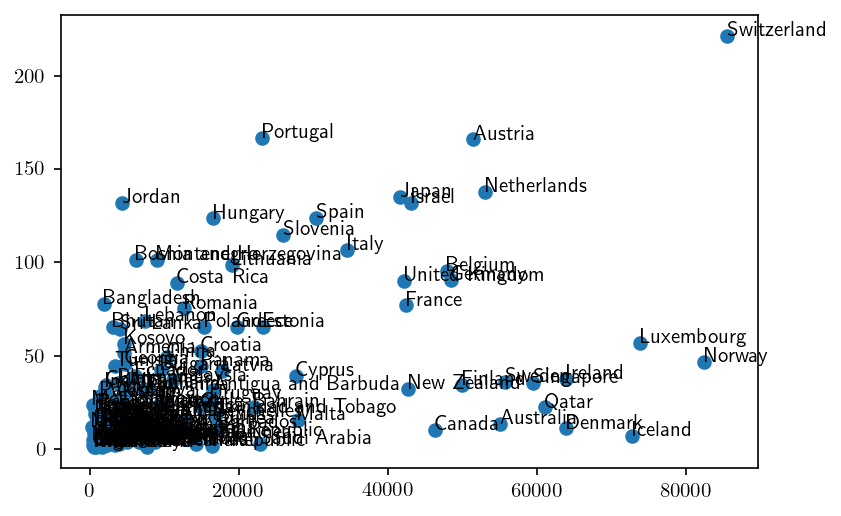

In [8]:
pdf = averages.merge(gdp, left_on="SOVEREIGNT", right_on="Country Name")
print(pdf.shape)

fig, ax = plt.subplots(dpi=150)

ax.scatter(pdf['2019'],pdf['total_study_prop'])

texts = []
for i, row in pdf.iterrows():
    ax.text(row['2019'],row['total_study_prop'],row['Country Name'])

pdf.head()

In [9]:
adm0shps

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,gridcells,index
0,Admin-0 country,1,3,Zimbabwe,ZWE,0,2,Sovereign country,Zimbabwe,ZWE,...,Zimbabwe,ZimbÃ¡bue,ÐÐ¸Ð¼Ð±Ð°Ð±Ð²Ðµ,Zimbabwe,Zimbabve,Zimbabwe,è¾å·´å¨,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344...",6.0,0
1,Admin-0 country,1,3,Zambia,ZMB,0,2,Sovereign country,Zambia,ZMB,...,Zambia,ZÃ¢mbia,ÐÐ°Ð¼Ð±Ð¸Ñ,Zambia,Zambiya,Zambia,èµæ¯äº,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643...",10.0,1
2,Admin-0 country,1,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,Jemen,IÃ©men,ÐÐµÐ¼ÐµÐ½,Jemen,Yemen,Yemen,ä¹é¨,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16...",7.0,2
3,Admin-0 country,3,2,Vietnam,VNM,0,2,Sovereign country,Vietnam,VNM,...,Wietnam,Vietname,ÐÑÐµÑÐ½Ð°Ð¼,Vietnam,Vietnam,Viá»t Nam,è¶å,"MULTIPOLYGON (((104.06396 10.39082, 104.08301 ...",5.0,3
4,Admin-0 country,5,3,Venezuela,VEN,0,2,Sovereign country,Venezuela,VEN,...,Wenezuela,Venezuela,ÐÐµÐ½ÐµÑÑÑÐ»Ð°,Venezuela,Venezuela,Venezuela,å§å §çæ,"MULTIPOLYGON (((-60.82119 9.13838, -60.94141 9...",12.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Admin-0 country,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,...,Albania,AlbÃ¢nia,ÐÐ»Ð±Ð°Ð½Ð¸Ñ,Albanien,Arnavutluk,Albania,é¿å°å·´å°¼äº,"POLYGON ((19.34238 41.86909, 19.34551 41.91885...",0.0,236
237,Admin-0 country,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,...,Afganistan,AfeganistÃ£o,ÐÑÐ³Ð°Ð½Ð¸ÑÑÐ°Ð½,Afghanistan,Afganistan,Afghanistan,é¿å¯æ±,"POLYGON ((66.52227 37.34849, 66.82773 37.37129...",9.0,237
238,Admin-0 country,1,5,Kashmir,KAS,0,2,Indeterminate,Siachen Glacier,KAS,...,Lodowiec Siachen,Glaciar de Siachen,Ð¡Ð¸Ð°ÑÐµÐ½,Siachen GlaciÃ¤ren,Siachen Buzulu,SÃ´ng bÄng Siachen,é¡äºç´å°å·,"POLYGON ((77.04863 35.10991, 77.00449 35.19634...",0.0,238
239,Admin-0 country,3,4,Antarctica,ATA,0,2,Indeterminate,Antarctica,ATA,...,Antarktyda,AntÃ¡rtida,ÐÐ½ÑÐ°ÑÐºÑÐ¸Ð´Ð°,Antarktis,Antarktika,ChÃ¢u Nam Cá»±c,åææ´²,"MULTIPOLYGON (((-45.71777 -60.52090, -45.49971...",977.0,239


Africa
['Zimbabwe' 'Zambia' 'Uganda' 'Tunisia' 'Togo'
 'United Republic of Tanzania' 'eSwatini' 'South Sudan' 'Sudan'
 'South Africa' 'Somalia' 'Sierra Leone' 'Senegal'
 'SÃ£o TomÃ© and Principe' 'Rwanda' 'Nigeria' 'Niger' 'Namibia'
 'Mozambique' 'Morocco' 'Mauritania' 'Mali' 'Malawi' 'Madagascar' 'Libya'
 'Liberia' 'Lesotho' 'Kenya' 'Guinea-Bissau' 'Guinea' 'Ghana' 'Gambia'
 'Gabon' 'Ethiopia' 'Eritrea' 'Equatorial Guinea' 'Egypt' 'Djibouti'
 'Ivory Coast' 'Democratic Republic of the Congo' 'Republic of the Congo'
 'Comoros' 'Chad' 'Central African Republic' 'Cabo Verde' 'Cameroon'
 'Burundi' 'Burkina Faso' 'Botswana' 'Benin' 'Angola' 'Algeria']
Asia
['Yemen' 'Vietnam' 'Uzbekistan' 'United Arab Emirates' 'Turkmenistan'
 'Turkey' 'East Timor' 'Thailand' 'Tajikistan' 'Taiwan' 'Syria'
 'Sri Lanka' 'South Korea' 'Singapore' 'Saudi Arabia' 'Qatar'
 'Philippines' 'Pakistan' 'Oman' 'North Korea' 'Nepal' 'Mongolia'
 'Malaysia' 'Lebanon' 'Laos' 'Kyrgyzstan' 'Kuwait' 'Kazakhstan' 'Jordan'
 'Jap

,SOVEREIGNT,total_study_prop,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,...,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,gridcells,index
0,Turkmenistan,0.656378,Turkmenistan,TKM,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,...,Turkmenistan,TurquemenistÃ£o,Ð¢ÑÑÐºÐ¼ÐµÐ½Ð¸Ñ,Turkmenistan,TÃ¼rkmenistan,Turkmenistan,ååºæ¼æ¯å¦,"MULTIPOLYGON (((53.10957 38.80308, 53.10020 38...",8.0,35
1,Libya,1.174230,Libya,LBY,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,NaN,...,Libia,LÃ­bia,ÐÐ¸Ð²Ð¸Ñ,Libyen,Libya,Libya,å©æ¯äº,"POLYGON ((9.51875 30.22939, 9.63799 30.28232, ...",24.0,122
2,Mauritania,1.504877,Mauritania,MRT,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,NaN,180.0,...,Mauretania,MauritÃ¢nia,ÐÐ°Ð²ÑÐ¸ÑÐ°Ð½Ð¸Ñ,Mauretanien,Moritanya,Mauritanie,æ¯éå¡å°¼äº,"MULTIPOLYGON (((-16.37334 19.70645, -16.43755 ...",15.0,111
3,Niger,1.641596,Niger,NER,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,150.0,160.0,...,Niger,NÃ­ger,ÐÐ¸Ð³ÐµÑ,Niger,Nijer,Niger,å°¼æ¥å°,"POLYGON ((13.60635 13.70459, 13.42695 13.70176...",16.0,91
4,Somalia,1.844048,Somalia,SOM,"GNI per capita, Atlas method (current US$)",NY.GNP.PCAP.CD,NaN,NaN,70.0,70.0,...,Somalia,SomÃ¡lia,Ð¡Ð¾Ð¼Ð°Ð»Ð¸,Somalia,Somali,Somalia,ç´¢é©¬é,"POLYGON ((41.53271 -1.69531, 41.53760 -1.61318...",7.0,57


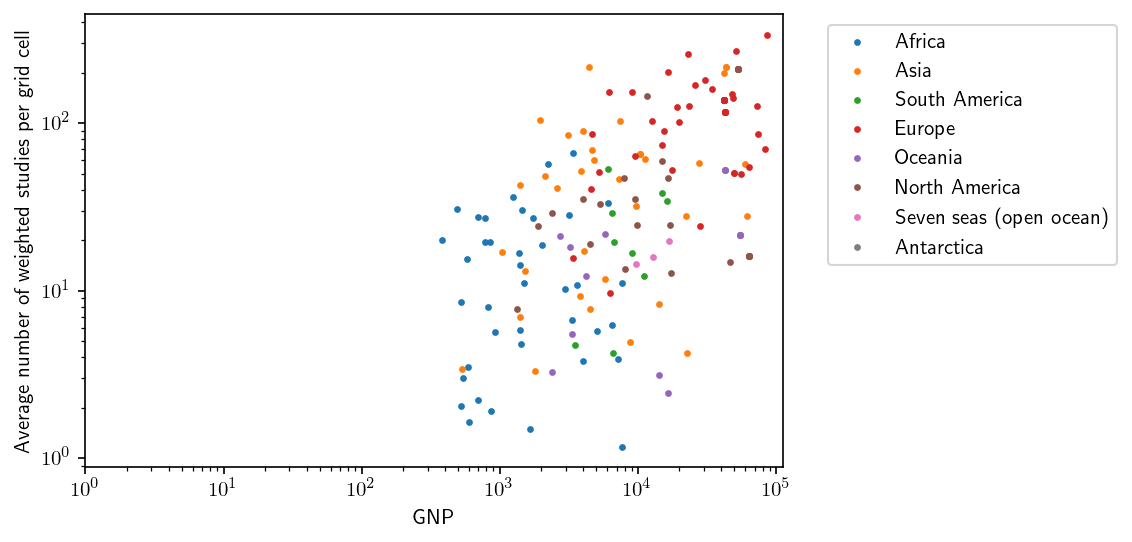

In [152]:
from adjustText import adjust_text
pdf = averages.merge(gdp, left_on="SOVEREIGNT", right_on="Country Name").merge(adm0shps)

fig, ax = plt.subplots(dpi=150)

for continent in adm0shps.CONTINENT.unique():
    countries = adm0shps[(adm0shps['CONTINENT']==continent) & (adm0shps['TYPE'].str.contains("ountry"))]['SOVEREIGNT'].unique()
    print(continent)
    print(countries)
    cdf = pdf[pdf['SOVEREIGNT'].isin(countries)]
    ax.scatter(cdf['2019'],cdf['total_study_prop'],s=5, label=continent)

# texts = []
# for i, row in pdf[pdf['TYPE'].str.contains("ountry")].iterrows():
#     texts.append(ax.text(row['2019'],row['total_study_prop'],row['Country Name'],fontsize=5))
    

    
ax.set_yscale('log')
ax.set_xscale('log')


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel('GNP')
ax.set_ylabel('Average number of weighted studies per grid cell')

ax.set_xlim(xmin=1)

pdf.head()

1. High Income
3. Upper middle income
4. Lower middle income
5. Low income


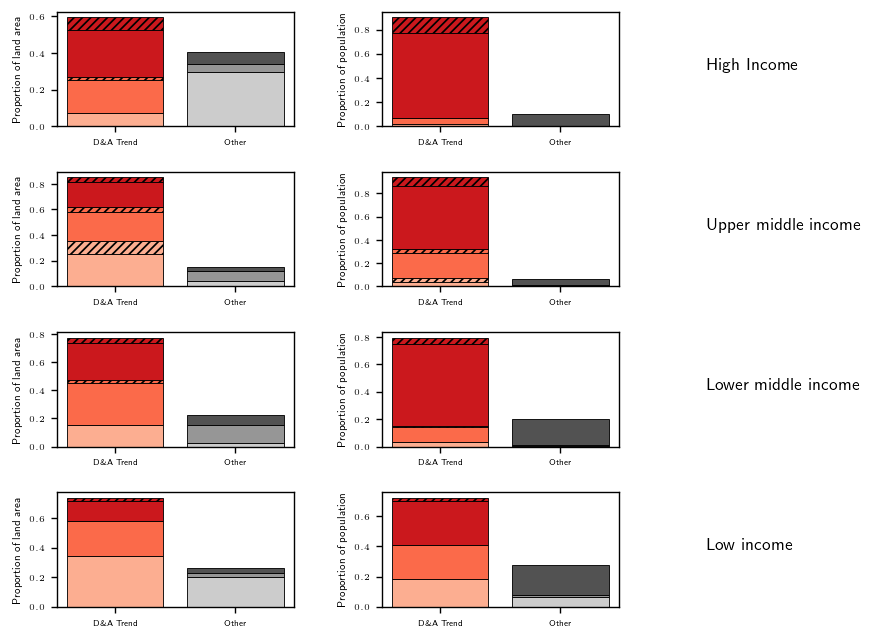

In [11]:
lots = 20
little = 5


#lots = 5
#little =1

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']<little),"evidence_cat"
] = 1

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']>=little),"evidence_cat"
] = 2

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']>=lots),"evidence_cat"
] = 3

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']<little),"evidence_cat"
] = 4

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']>=little),"evidence_cat"
] = 5

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']>=lots),"evidence_cat"
] = 6



#fig, axs = plt.subplots(5,2,dpi=150, sharey=True, figsize=(8,12))
fig = plt.figure(figsize=(7.2,8), dpi=125, constrained_layout=False)
gs = fig.add_gridspec(5, 3, width_ratios=[1,1,0.2],figure=fig,wspace=0.5,hspace=0.4)

shp_ndf_df['Income category'] = shp_ndf_df['INCOME_GRP']
shp_ndf_df.loc[shp_ndf_df['Income category']=="1. High income: OECD","Income category"] = "1. High Income"
shp_ndf_df.loc[shp_ndf_df['Income category']=="2. High income: nonOECD","Income category"] = "1. High Income"


row = 0
for name, group in shp_ndf_df.groupby('Income category'):
    
    print(name)
    
    
    
    cells = ndf[ndf['index'].isin(group['ndf_id'])]
    
    area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
    area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
    
    pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
    pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
    
    bottoms = {0: 0.0, 1: 0.0}

    hatch_types = ["","","/////"]

    greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
    reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]
    colors = reds + greys 
    
    ax = fig.add_subplot(gs[row, 2])
    
    ax.text(0,0.5,name.split(".")[1].strip())
    
    ax.axis('off')
    
    ax = fig.add_subplot(gs[row, 0])
    
    

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of land area",fontsize=6)

    ax = fig.add_subplot(gs[row, 1])

    bottoms = {0: 0.0, 1: 0.0}

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(pop_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of population",fontsize=6)
    
    row+=1
    


1. High Income
3. Upper middle income
4. Lower middle income
5. Low income


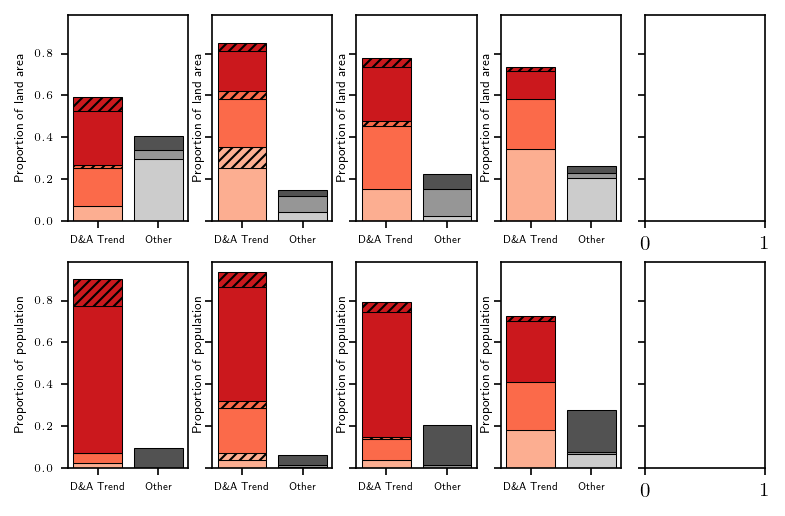

In [12]:
lots = 20
little = 5


#lots = 5
#little =1

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']<little),"evidence_cat"
] = 1

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']>=little),"evidence_cat"
] = 2

ndf.loc[
    (abs(ndf['n_da_impacts'])>0) & (ndf['total_study_prop']>=lots),"evidence_cat"
] = 3

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']<little),"evidence_cat"
] = 4

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']>=little),"evidence_cat"
] = 5

ndf.loc[
    (abs(ndf['n_da_impacts'])==0) & (ndf['total_study_prop']>=lots),"evidence_cat"
] = 6



#fig, axs = plt.subplots(5,2,dpi=150, sharey=True, figsize=(8,12))
fig, axs = plt.subplots(2,5, dpi=150, sharey=True)

shp_ndf_df['Income category'] = shp_ndf_df['INCOME_GRP']
shp_ndf_df.loc[shp_ndf_df['Income category']=="1. High income: OECD","Income category"] = "1. High Income"
shp_ndf_df.loc[shp_ndf_df['Income category']=="2. High income: nonOECD","Income category"] = "1. High Income"


row = 0
for name, group in shp_ndf_df.groupby('Income category'):
    
    print(name)
    
    
    
    cells = ndf[ndf['index'].isin(group['ndf_id'])]
    
    area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
    area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
    
    pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
    pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
    
    bottoms = {0: 0.0, 1: 0.0}

    hatch_types = ["","","/////"]

    greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
    reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]
    colors = reds + greys 
    
#     ax = axs[0,row]
    
#     ax.text(0,0.5,name.split(".")[1].strip())
    
#     ax.axis('off')
    
    ax = axs[0, row]
    
    

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of land area",fontsize=6)

    ax = axs[1, row]

    bottoms = {0: 0.0, 1: 0.0}

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(pop_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of population",fontsize=6)
    
    row+=1
    


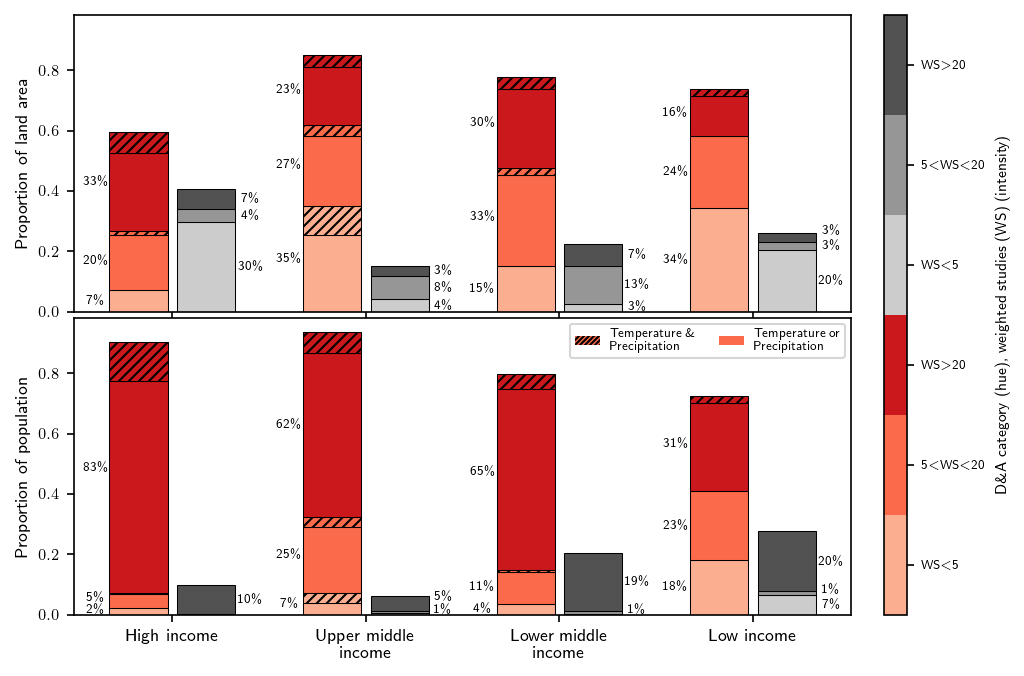

In [149]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, dpi=150, figsize=(7.4,5))


from matplotlib.patches import Rectangle, Patch

offsets = [0.15,-0.15]

labels = ["Proportion of land area","Proportion of population"]

texts = []

for k in [0,1]:
    income_x = 0
    ax = axs[k]
    ax.set_ylabel(labels[k], fontsize=8)

    handles = [[],[]]
    
    for inc, group in shp_ndf_df.groupby('Income category'):
        cells = ndf[ndf['index'].isin(group['ndf_id'])]

        area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
        area_sums['prop'] = area_sums['area']/area_sums['area'].sum()

        pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
        pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
        
        sums = [area_sums, pop_sums][k]

        bottoms = {0: 0.0, 1: 0.0}
        


        with mpl.rc_context(rc={'hatch.linewidth': 2}):
            
            ys = []
            


            for i, (name, group) in enumerate(sums.groupby('evidence_cat')):
                x = name//4 
                if bottoms[x]==0:
                    ys = []
                y = bottoms[x]+group['prop'].sum()*0.5
                if y>0.005:
                    ys.append(y)
                    if len(ys)>1:
                        min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                        while min_distance < 0.04:
                            y+=0.01
                            ys[-1] = y
                            min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                    texts.append(ax.text(
                        x + income_x + offsets[int(x)]*-2,max(y,0.015), 
                        f"{group['prop'].sum():.0%}".replace("%","\%"),
                        ha="center",va="center", fontsize=6
                    ))
                for j, group in group.groupby('n_da_impacts'):
                    y = group['prop'].values[0]
                    b = ax.bar(
                        x + income_x + offsets[int(x)],y, bottom=bottoms[x], 
                        color=colors[i], hatch=hatch_types[j],
                        edgecolor="black",
                        linewidth=0.5,
                        width=0.6
                    )
                    bottoms[x]+=y
                    if "Upper" in inc:
                        #print(int(x))
                        #print(colors[i])
                        handles[int(x)] = handles[int(x)] + [b]
                        #print([bp.patches[0].get_fc() for bp in handles[0]])
                

        income_x+=2
        
    ax.tick_params(axis='y', labelsize=7)
        
        
ax.set_xticks([0.5,2.5,4.5,6.5])
ax.set_xticklabels(["High income", "Upper middle\nincome","Lower middle\nincome","Low income"], fontsize=8)

#ax.legend(handles[0])

greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]
colors = reds + greys 
cmap = mpl.colors.ListedColormap(colors)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])

sm = plt.cm.ScalarMappable(cmap=cmap)
sm._A = np.arange(7)
cbar = fig.colorbar(sm, shrink=0.95, cax=cb_ax)
cbar.set_ticks(np.array(np.linspace(0,cmap.N,cmap.N+1)[:-1]+0.5))
#cbar.set_ticks([0.5,1.3])

cbar.set_ticklabels([
    fr"WS\textless{little}",
    fr"{little}\textless WS\textless{lots}",
    fr"WS\textgreater{lots}"
]*2)

cbar.set_label('D\&A category (hue), weighted studies (WS) (intensity)', fontsize=7, labelpad=5)
cbar.ax.tick_params(labelsize=6)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    hatch="//////////",
    label="Temperature \&\n Precipitation",
)

ax.add_patch(rect)

rect = Rectangle(
    (0, 0),0,0,
    facecolor=reds[1],
    label="Temperature or\n Precipitation",
)

ax.add_patch(rect)
ax.legend(fontsize=6, loc="upper right", ncol=2)

[]

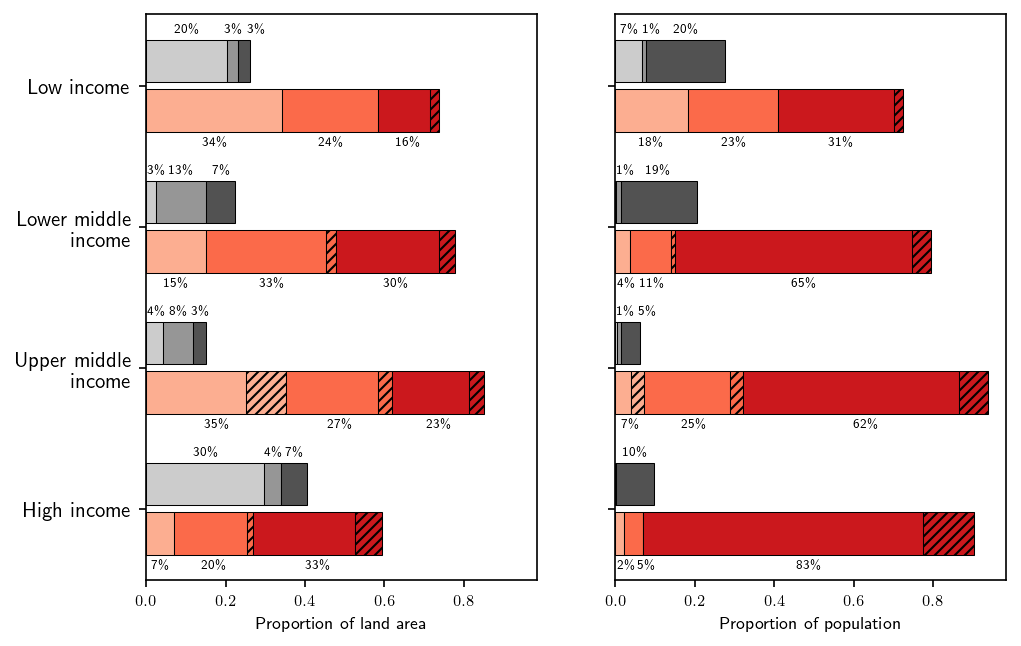

In [161]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, dpi=150, figsize=(7.4,5))


from matplotlib.patches import Rectangle, Patch

offsets = [0.15,-0.15]

labels = ["Proportion of land area","Proportion of population"]

texts = []

for k in [0,1]:
    income_x = 0
    ax = axs[k]
    ax.set_xlabel(labels[k], fontsize=8)

    handles = [[],[]]
    
    for inc, group in shp_ndf_df.groupby('Income category'):
        cells = ndf[ndf['index'].isin(group['ndf_id'])]

        area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
        area_sums['prop'] = area_sums['area']/area_sums['area'].sum()

        pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
        pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
        
        sums = [area_sums, pop_sums][k]

        bottoms = {0: 0.0, 1: 0.0}
        


        with mpl.rc_context(rc={'hatch.linewidth': 2}):
            
            ys = []
            


            for i, (name, group) in enumerate(sums.groupby('evidence_cat')):
                x = name//4 
                if bottoms[x]==0:
                    ys = []
                y = bottoms[x]+group['prop'].sum()*0.5
                if y>0.005:
                    ys.append(max(y,0.025))
                    if len(ys)>1:
                        min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                        while min_distance < 0.05:
                            y+=0.01
                            ys[-1] = y
                            min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                    texts.append(ax.text(
                        max(y,0.025),x + income_x + offsets[int(x)]*-2, 
                        f"{group['prop'].sum():.0%}".replace("%","\%"),
                        ha="center",va="center", fontsize=6
                    ))
                for j, group in group.groupby('n_da_impacts'):
                    y = group['prop'].values[0]
                    b = ax.barh(
                        x + income_x + offsets[int(x)],y, left=bottoms[x], 
                        color=colors[i], hatch=hatch_types[j],
                        edgecolor="black",
                        linewidth=0.5,
                        height=0.6
                    )
                    bottoms[x]+=y
                    if "Upper" in inc:
                        #print(int(x))
                        #print(colors[i])
                        handles[int(x)] = handles[int(x)] + [b]
                        #print([bp.patches[0].get_fc() for bp in handles[0]])
                

        income_x+=2
        
    ax.tick_params(axis='x', labelsize=7)
        
        
ax.set_yticks([0.5,2.5,4.5,6.5])
ax.set_yticklabels(["High income", "Upper middle\nincome","Lower middle\nincome","Low income"], fontsize=8)

In [163]:
shp_ndf_df.to_csv('../data/2_country_data.csv',index=False)

In [119]:
print([bp.patches[0].get_fc() for bp in handles[0]])

[(0.9882352941176471, 0.6823529411764706, 0.5686274509803921, 1.0), (0.9882352941176471, 0.6823529411764706, 0.5686274509803921, 1.0), (0.984313725490196, 0.41568627450980394, 0.2901960784313726, 1.0), (0.984313725490196, 0.41568627450980394, 0.2901960784313726, 1.0), (0.796078431372549, 0.09411764705882353, 0.11372549019607843, 1.0), (0.796078431372549, 0.09411764705882353, 0.11372549019607843, 1.0)]


[Text(0.5, 0, 'Africa'),
 Text(2.5, 0, 'Antarctica'),
 Text(4.5, 0, 'Asia'),
 Text(6.5, 0, 'Europe'),
 Text(8.5, 0, 'North America'),
 Text(10.5, 0, 'Oceania'),
 Text(12.5, 0, 'Seven seas (open ocean)'),
 Text(14.5, 0, 'South America')]

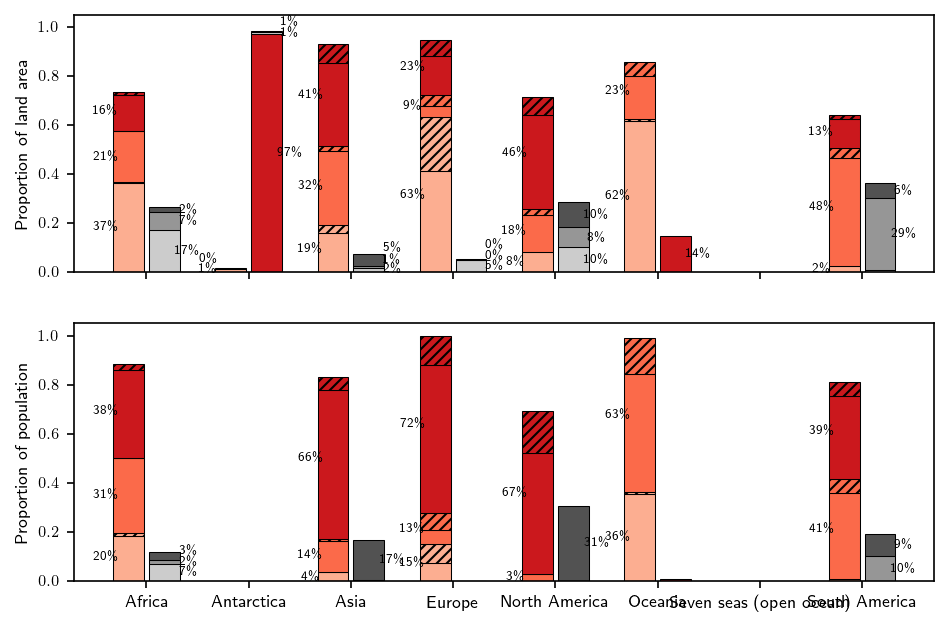

In [107]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, dpi=150, figsize=(7.4,5))



offsets = [0.15,-0.15]

labels = ["Proportion of land area","Proportion of population"]

texts = []



for k in [0,1]:
    income_x = 0
    ax = axs[k]
    ax.set_ylabel(labels[k], fontsize=8)

    handles = [[],[]]
    
    xticklabels = []
    
    for inc, group in shp_ndf_df.groupby('CONTINENT'):
        xticklabels.append(inc)
        cells = ndf[ndf['index'].isin(group['ndf_id'])]

        area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
        area_sums['prop'] = area_sums['area']/area_sums['area'].sum()

        pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
        pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
        
        sums = [area_sums, pop_sums][k]

        bottoms = {0: 0.0, 1: 0.0}
        


        with mpl.rc_context(rc={'hatch.linewidth': 2}):
            
            ys = []
            


            for i, (name, group) in enumerate(sums.groupby('evidence_cat')):
                x = name//4 
                if bottoms[x]==0:
                    ys = []
                y = bottoms[x]+group['prop'].sum()*0.5
                if y>0.005:
                    ys.append(y)
                    if len(ys)>1:
                        min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                        while min_distance < 0.04:
                            y+=0.01
                            ys[-1] = y
                            min_distance = np.min([abs(x[0]-x[1]) for x in itertools.combinations(ys,2)])
                    texts.append(ax.text(
                        x + income_x + offsets[int(x)]*-2,max(y,0.015), 
                        f"{group['prop'].sum():.0%}".replace("%","\%"),
                        ha="center",va="center", fontsize=6
                    ))
                for j, group in group.groupby('n_da_impacts'):
                    y = group['prop'].values[0]
                    b = ax.bar(
                        x + income_x + offsets[int(x)],y, bottom=bottoms[x], 
                        color=colors[i], hatch=hatch_types[j],
                        edgecolor="black",
                        linewidth=0.5,
                        width=0.6
                    )
                    bottoms[x]+=y
                    if "Upper" in inc:
                        print(int(x))
                        print(colors[i])
                        handles[int(x)] = handles[int(x)] + [b]
                        print(handles)
                

        income_x+=2
        
    ax.tick_params(axis='y', labelsize=7)
        
        
ax.set_xticks(np.arange(len(xticklabels))*2+.5)
ax.set_xticklabels(xticklabels, fontsize=8)



# greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
# reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]
# colors = reds + greys 
# cmap = mpl.colors.ListedColormap(colors)

# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
#                     wspace=0.02, hspace=0.02)

# cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])

# sm = plt.cm.ScalarMappable(cmap=cmap)
# # fake up the array of the scalar mappable. Urgh…
# sm._A = []
# cbar = fig.colorbar(sm, shrink=0.95, cax=cb_ax)


In [102]:
xticklabels

['Africa',
 'Antarctica',
 'Asia',
 'Europe',
 'North America',
 'Oceania',
 'Seven seas (open ocean)',
 'South America']

Africa
Antarctica
Asia
Europe
North America
Oceania
Seven seas (open ocean)


IndexError: index 6 is out of bounds for axis 0 with size 6

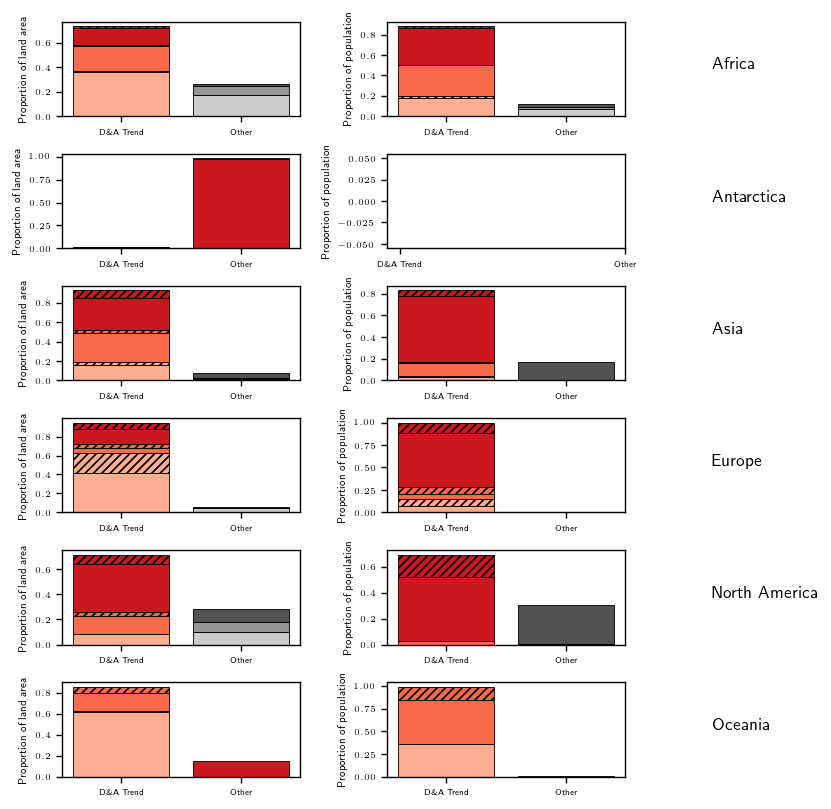

In [14]:
#fig, axs = plt.subplots(5,2,dpi=150, sharey=True, figsize=(8,12))
fig = plt.figure(figsize=(7.2,8), dpi=125, constrained_layout=False)
gs = fig.add_gridspec(6, 3, width_ratios=[1,1,0.2],figure=fig,wspace=0.5,hspace=0.4)


row = 0
for name, group in shp_ndf_df.groupby('CONTINENT'):
    
    print(name)
    
    
    
    cells = ndf[ndf['index'].isin(group['ndf_id'])]
    
    area_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
    area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
    
    pop_sums = cells[cells['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['population'].sum().reset_index()
    pop_sums['prop'] = pop_sums['population']/pop_sums['population'].sum()
    
    bottoms = {0: 0.0, 1: 0.0}

    hatch_types = ["","","/////"]

    greys = ['#f7f7f7','#cccccc','#969696','#525252'][1:]
    reds = ['#fee5d9','#fcae91','#fb6a4a','#cb181d'][1:]
    colors = reds + greys 
    
    ax = fig.add_subplot(gs[row, 2])
    
    ax.text(0,0.5,name)
    
    ax.axis('off')
    
    ax = fig.add_subplot(gs[row, 0])
    
    

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(area_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of land area",fontsize=6)

    ax = fig.add_subplot(gs[row, 1])

    bottoms = {0: 0.0, 1: 0.0}

    with mpl.rc_context(rc={'hatch.linewidth': 2}):

        for i, (name, group) in enumerate(pop_sums.groupby('evidence_cat')):
            x = name//4
            for j, group in group.groupby('n_da_impacts'):
                y = group['prop'].values[0]
                ax.bar(
                    x,y, bottom=bottoms[x], 
                    color=colors[i], hatch=hatch_types[j],
                    edgecolor="black",
                    linewidth=0.5
                )
                bottoms[x]+=y

    ax.set_xticks([0,1])
    ax.set_xticklabels(["D\&A Trend", "Other"], fontsize=5)

    ax.tick_params(axis="y",labelsize=5)

    ax.set_ylabel("Proportion of population",fontsize=6)
    
    row+=1
    

In [ ]:
area_sums = ndf[ndf['is_land']==True].groupby(['evidence_cat','n_da_impacts'])['area'].sum().reset_index()
area_sums['prop'] = area_sums['area']/area_sums['area'].sum()
area_sums